In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)

In [2]:
cutoff <- 0.05

# Load data

In [3]:
variants_map_df <- vroom::vroom(
    "/data2/michael/data_resources/ukbiobank/hapmap3_genotypes/hapmap3_variants_map.txt", 
    delim = " ", col_names = c("chr_pos", "rsid"), show_col_types = F, 
    col_types = cols(chr_pos = col_character(), rsid = col_character())
) %>% distinct

megastroke_df <- fs::dir_ls("../data/megastroke/", glob = "*MEGASTROKE.*.EUR.out") %>%
        vroom::vroom(
        id = "mega_type", col_select = c("MarkerName", "P-value"),
        show_col_types = F
    ) %>% 
    rename(rsid = MarkerName, P_mega = `P-value`) %>%
    inner_join(variants_map_df, by = "rsid") %>%
    mutate(
        mega_type = mega_type %>% 
            str_remove("^\\.\\./data/megastroke/MEGASTROKE\\.") %>%
            str_remove("\\.EUR\\.out$")
    ) %>%
    select(mega_type, ID = chr_pos, P_mega) %>%
    mutate(truth = factor(P_mega < cutoff, levels = c("TRUE", "FALSE")))

megastroke_df %>% head(2)

mega_type,ID,P_mega,truth
<chr>,<chr>,<dbl>,<fct>
1.AS,11:100009976,0.3977,FALSE
1.AS,1:166367755,0.8106,FALSE


In [4]:
naive_df <- fs::dir_ls("data/gwas/", glob = "*naive.*b_I63.glm.linear") %>%
    vroom::vroom(
        id = "source", col_select = c("ID", "P"), show_col_types = F,
        col_types = cols(ID = col_character(), P = col_double())
    ) %>%
    mutate(phenotype_id = str_extract(source, "(?<=naive\\.).+(?=\\.glm\\.linear)")) %>%
    select(phenotype_id, ID, P)

naive_df %>% head(2)

phenotype_id,ID,P
<chr>,<chr>,<dbl>
b_I63,1:752566,0.519455
b_I63,1:752721,0.459446


In [5]:
maxgcp_df <- fs::dir_ls("data/gwas/", glob = "*maxgcp*.glm.linear.zst") %>%
    map(
        ~read_tsv_arrow(.x, col_types = schema(ID = utf8(), P = float64())) %>% 
        mutate(phenotype_id = str_extract(.x, "(?<=maxgcp\\.).+(?=\\.glm)"))
    ) %>%
    list_rbind %>%
    select(phenotype_id, ID, P) %>%
    mutate(mega_type = phenotype_id %>% str_extract("[0-5]\\.[A-Z]+$"))

maxgcp_df %>% head(2)

phenotype_id,ID,P,mega_type
<chr>,<chr>,<dbl>,<chr>
maxgcp_full_1.AS,1:752566,0.491535,1.AS
maxgcp_full_1.AS,1:752721,0.535830,1.AS


# Perform comparison

In [6]:
raw_comparison_df <- bind_rows(
        megastroke_df %>%
            inner_join(maxgcp_df, by = c("ID", "mega_type")),
        megastroke_df %>%
            inner_join(naive_df, by = c("ID"), relationship = "many-to-many")
    ) %>%
    mutate(
        estimate = factor(P < cutoff, levels = c("TRUE", "FALSE")),
        phenotype_id = phenotype_id %>% 
            str_remove_all("_1.AS|_2.AIS|_3.LAS|_4.CES|_5.SVS") %>%
            recode_factor(
                maxgcp_full = "MaxGCP (N=350k)",
                b_I63 = "Naive (N=350k)",
                maxgcp_sub = "MaxGCP (N=15k)",
                sub_b_I63 = "Naive (N=15k)",                
            ),
        mega_type = mega_type %>%
            recode_factor(
                `1.AS` = "Any",
                `2.AIS` = "Ischemic",
                `3.LAS` = "Large artery",
                `4.CES` = "Cardioembolic",
                `5.SVS` = "Small vessel"
            )
    )

In [7]:
summary_df <- raw_comparison_df %>%
    group_by(mega_type, phenotype_id) %>%
    summarize(
        n_variants = n(),
        n_true = sum(truth == "TRUE"),
        n_estimated = sum(estimate == "TRUE"),
        n_true_positives = sum(truth == "TRUE" & estimate == "TRUE"),
        sensitivity = sensitivity_vec(truth, estimate),
        specificity = specificity_vec(truth, estimate),
        auroc = roc_auc_vec(truth, -log10(P)),
        f1 = f_meas_vec(truth, estimate),
        .groups = "drop"
    ) %>%
    filter(mega_type != "Large artery")

summary_df %>% write_parquet("plot_data/summary.parquet")

In [8]:
roc_df <- raw_comparison_df %>%
    filter(mega_type != "Large artery") %>%
    group_by(mega_type, phenotype_id) %>%
    mutate(nlogp = -log10(P)) %>%
    roc_curve(truth, nlogp)

roc_df %>% write_parquet("plot_data/roc_curves.parquet")

In [9]:
target_sensitivity_specificity_df <- bind_rows(
    roc_df %>%
        filter(specificity >= 0.9) %>%
        filter(.threshold == min(.threshold)) %>%
        mutate(metric = "Sensitivity\n(at 90% specificity)") %>%
        select(mega_type, phenotype_id, metric, value = sensitivity),
    roc_df %>%
        filter(sensitivity >= 0.1) %>%
        filter(.threshold == max(.threshold)) %>%
        mutate(metric = "Specificity\n(at 10% sensitivity)") %>%
        select(mega_type, phenotype_id, metric, value = specificity)
)

target_sensitivity_specificity_df %>% 
    write_parquet("plot_data/target_sensitivity_specificity.parquet")

# Plot results

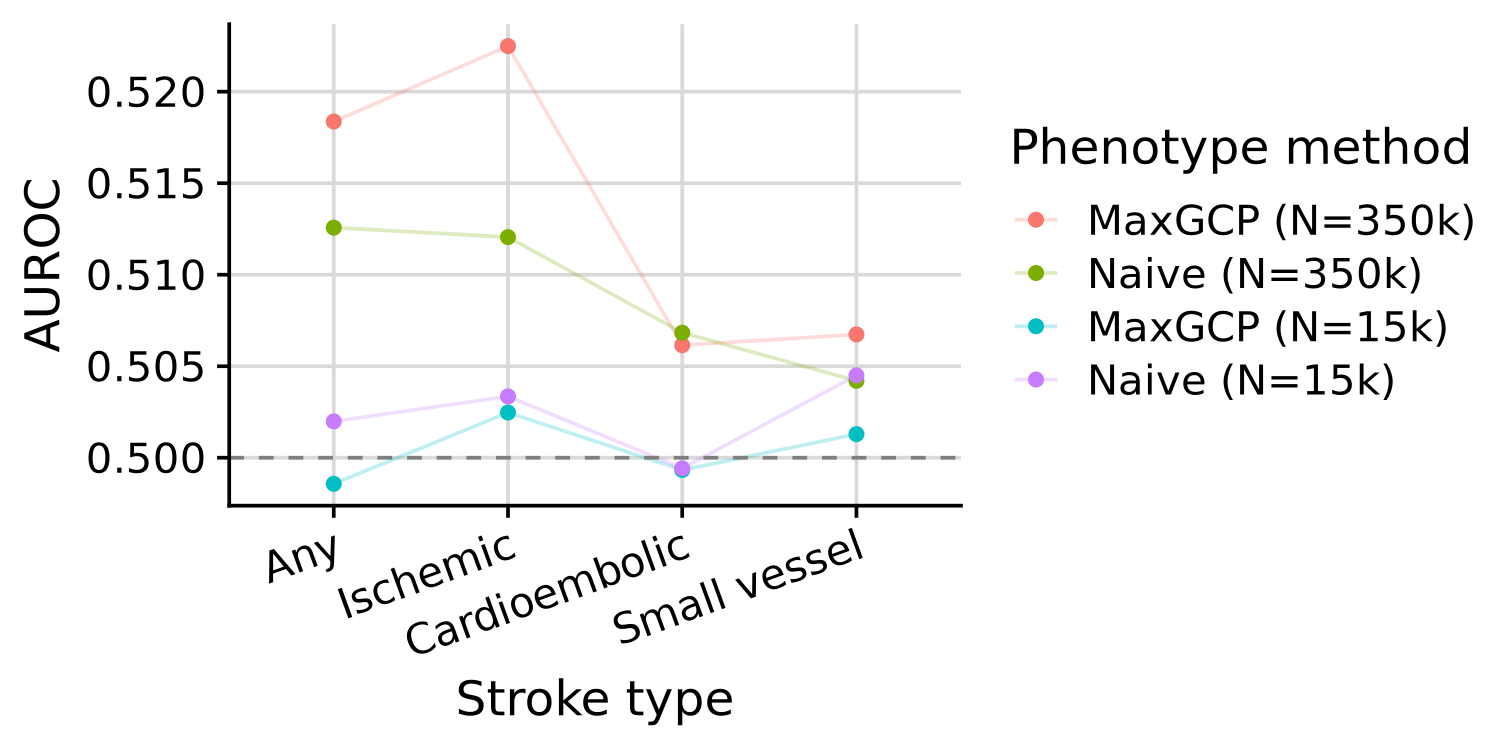

In [10]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

summary_df <- read_parquet("plot_data/summary.parquet")

auroc_plot <- summary_df %>%
    ggplot(aes(x = mega_type, y = auroc, color = phenotype_id, group = phenotype_id)) +
    geom_line(alpha = 0.25) +
    geom_point() +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    background_grid() +
    ylab("AUROC") +
    xlab("Stroke type") +
    scale_color_discrete(name = "Phenotype method") +
    theme(
        axis.text.x = element_text(angle = 20, hjust = 1)
    )

save_plot("img/auroc.png", auroc_plot, base_width = 6, base_height = 3, dpi = 400)

auroc_plot

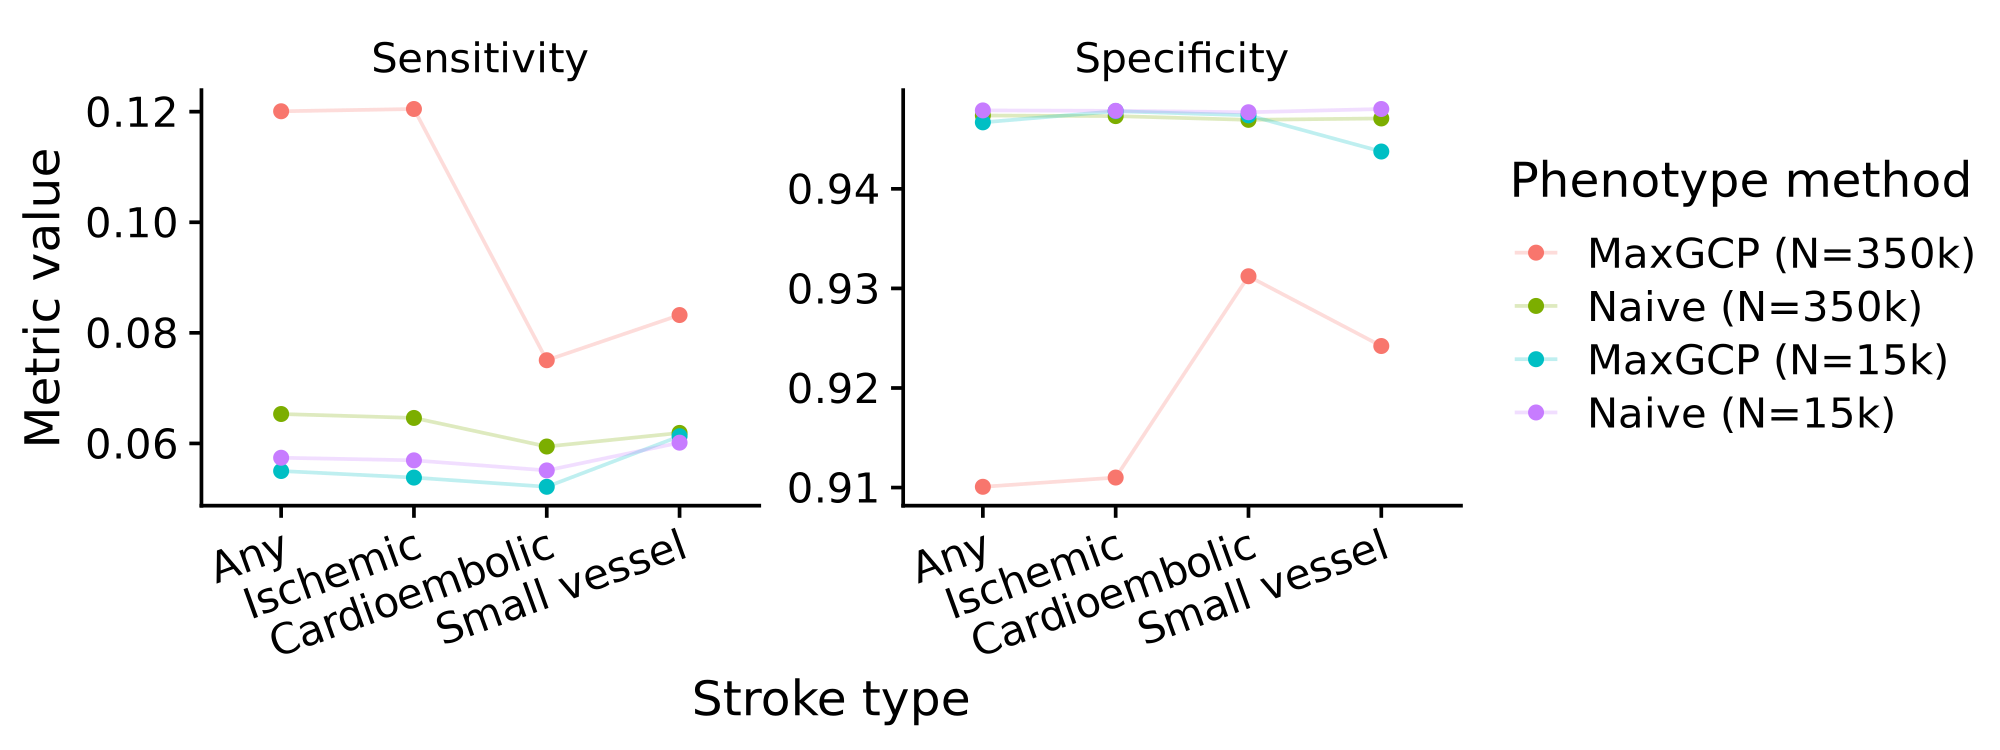

In [11]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 250)

sens_spec_plot <- summary_df %>%
    pivot_longer(c(sensitivity, specificity), names_to = "metric") %>%
    mutate(metric = metric %>% str_to_sentence) %>%
    ggplot(aes(x = mega_type, y = value, color = phenotype_id, group = phenotype_id)) +
    geom_line(alpha = 0.25) +
    geom_point() +
    facet_wrap(vars(metric), scales = "free") +
    theme_cowplot() +
    ylab("Metric value") +
    xlab("Stroke type") +
    scale_color_discrete(name = "Phenotype method") +
    theme(
        axis.text.x = element_text(angle = 20, hjust = 1),
        strip.background = element_blank(),
    )

save_plot("img/sens_spec.png", sens_spec_plot, base_width = 8, base_height = 3, dpi = 400)

sens_spec_plot

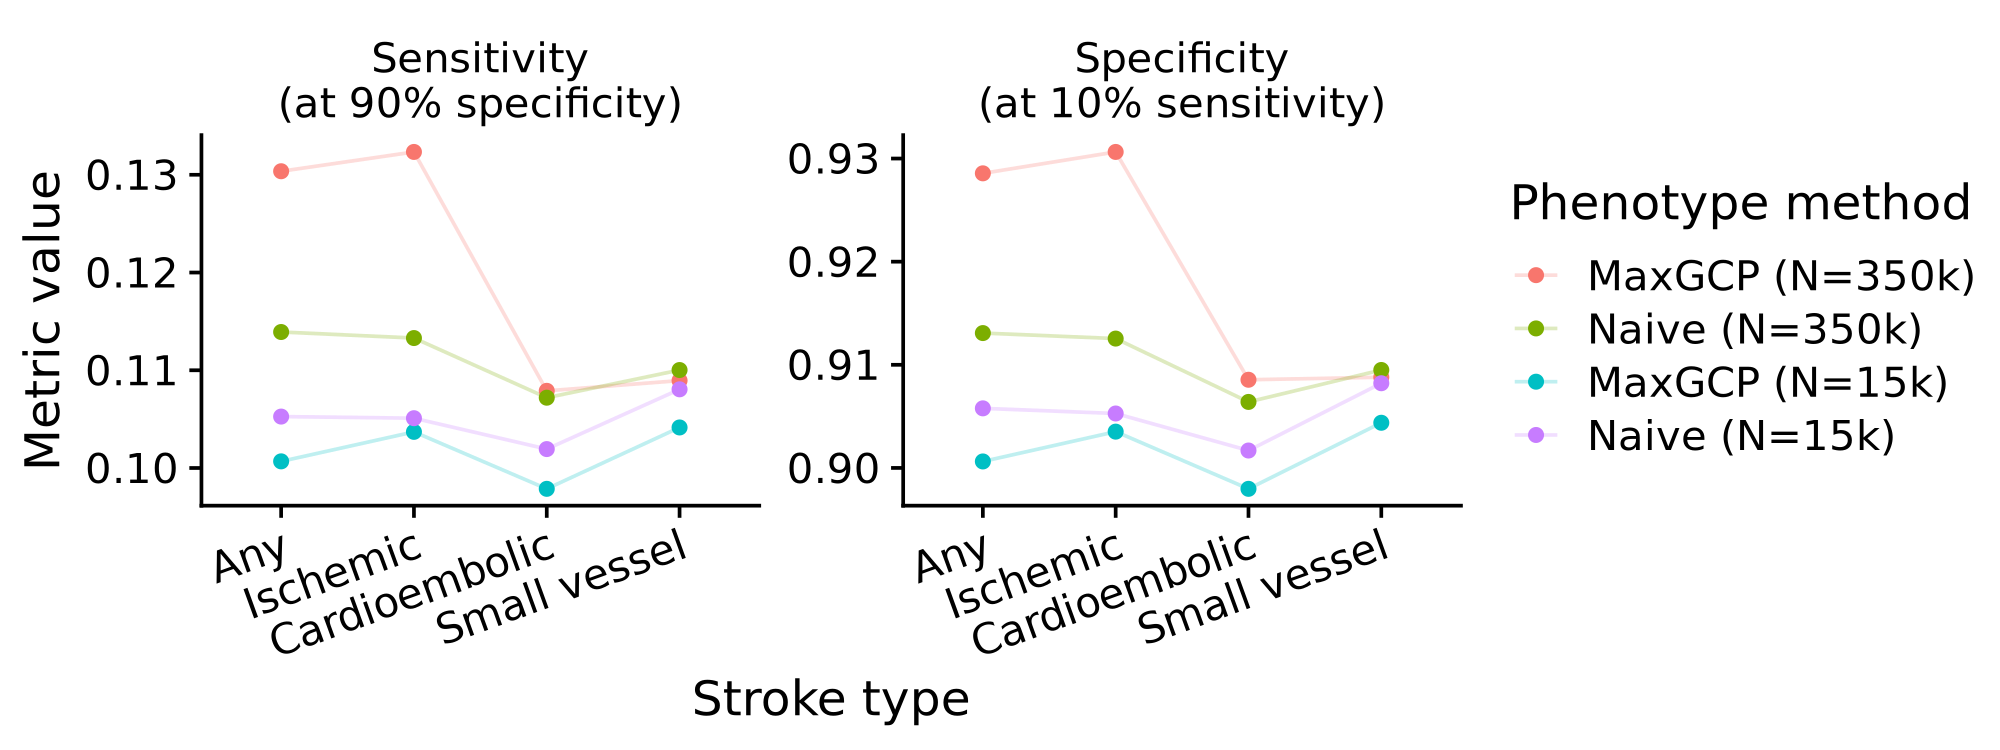

In [12]:
target_sensitivity_specificity_df <- read_parquet(
    "plot_data/target_sensitivity_specificity.parquet")

target_sens_spec_plot <- target_sensitivity_specificity_df %>%
    ggplot(aes(x = mega_type, y = value, color = phenotype_id, group = phenotype_id)) +
    geom_line(alpha = 0.25) +
    geom_point() +
    facet_wrap(vars(metric), scales = "free") +
    theme_cowplot() +
    ylab("Metric value") +
    xlab("Stroke type") +
    scale_color_discrete(name = "Phenotype method") +
    theme(
        axis.text.x = element_text(angle = 20, hjust = 1),
        strip.background = element_blank(),
    )

save_plot("img/target_sens_spec.png", target_sens_spec_plot, base_width = 8, base_height = 3, dpi = 400)

target_sens_spec_plot